<a href="https://colab.research.google.com/github/joaopcnogueira/colab-notebooks/blob/main/PSI_for_Dummies_and_Numerical_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Apenas para LEITURA!

# Jamais Executar este Notebook!

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Loading Data

In [ ]:
df = pd.read_csv('../data/TabelaModelagemQuebra17fev2021.csv.gz', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (65,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

,OrigemDadoId,CertificadoName,riscoid,ProdutoAtuarialId,filial_ml,CoberturaId,RamoId,ProdutoComercialId,ProdutoGarantiaId,Parceiroid,...,clientedatanascimento,clientesexo,clienteidade,clientegeografiaUF,clientegeografiacidade,clientegeografiacep,ClienteGeografiaBairro,clientegeografiaregiao,cep3,target
0,2,1529458504,150,2590,30.0,1182,8,758,563233.0,286,...,1988-01-02,F,31.0,SP,JAU,17213366,Jardim Padre Augusto Sani,Sudeste,172,0
1,2,1529458988,150,2590,561.0,1182,8,758,559815.0,286,...,1977-06-24,M,42.0,SP,GUARULHOS,7132166,Jardim Vera,Sudeste,71,0
2,2,1529459224,150,2590,420.0,1182,8,758,589218.0,286,...,1900-01-01,N,0.0,RS,CANOAS,92412230,Igara,Sul,924,0
3,2,714509601,150,2590,820.0,1182,8,758,393463.0,286,...,1900-01-01,N,0.0,CE,CRATO,63102070,Vila Lobo,Nordeste,631,0
4,2,714512745,150,2590,542.0,1182,8,758,393840.0,286,...,1981-12-23,M,35.0,SP,SAO PAULO,3941020,Jardim Paraguaçu,Sudeste,39,0


In [ ]:
df['target'].value_counts(1)

0    0.941
1    0.059
Name: target, dtype: float64

# Listando as Variáveis de Modelagem

Fazendo aqui porque dentro do pipeline não funciona.

In [ ]:
num_features = ['ISeg', 'clienteidade']
cat_features_high_card = ['cep3', 'clientegeografiacidade']
cat_features_low_card  = ['marca2', 'linha', 'Parceirodescricaoreduzida', 
                          'clientegeografiaregiao', 'clientegeografiaUF', 'clientesexo']
cat_features = cat_features_high_card + cat_features_low_card

features = num_features + cat_features
target = 'target'

# Separando em Treino/Teste/OOT

In [ ]:
X_train = df.query('datainiciovigencia < "2020-01-01"')[features].copy()
y_train = df.query('datainiciovigencia < "2020-01-01"')[target].copy()

X_test = df.query('datainiciovigencia >= "2020-01-01" and datainiciovigencia < "2020-03-01"')[features].copy()
y_test = df.query('datainiciovigencia >= "2020-01-01" and datainiciovigencia < "2020-03-01"')[target].copy()

X_oot = df.query('datainiciovigencia >= "2020-03-01" and datainiciovigencia < "2020-05-01"')[features].copy()
y_oot = df.query('datainiciovigencia >= "2020-03-01" and datainiciovigencia < "2020-05-01"')[target].copy()

# Feature Engineering

In [ ]:
# pipeline de transformação da abt
num_pipe = Pipeline(steps=[
    ('numeric_imputer', SimpleImputer(strategy='mean'))
])

cat_pipe_high_card = Pipeline(steps=[
    ('categoric_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('count_encoder', ce.CountEncoder(normalize=True, min_group_size=len(cat_features_high_card)))
])

cat_pipe_low_card = Pipeline(steps=[
    ('categoric_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

transformer = ColumnTransformer([("numeric", num_pipe, num_features),
                                 ("categoric_high", cat_pipe_high_card, cat_features_high_card),
                                 ("categoric_low", cat_pipe_low_card, cat_features_low_card)])

In [ ]:
from sklearn import set_config

set_config(display='diagram')
transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('numeric_imputer',
                                                  SimpleImputer())]),
                                 ['ISeg', 'clienteidade']),
                                ('categoric_high',
                                 Pipeline(steps=[('categoric_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('count_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=2,
                                                               normalize=True))]),
                                 ['cep3', 'clientegeografiacidade']),
                                ('categoric_low',
                                 Pipeline(steps=[('categoric_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['marca2', 'linha',
                                  'Parceirodescricaoreduzida',
                                  'clientegeografiaregiao',
                                  'clientegeografiaUF', 'clientesexo'])])

In [ ]:
X_train = transformer.fit_transform(X_train, y_train)
X_test  = transformer.transform(X_test)
X_oot   = transformer.transform(X_oot)

name_transformed_features=num_features+cat_features_high_card+list(transformer.transformers_[-1][1].steps[-1][-1].get_feature_names(cat_features_low_card))

In [ ]:
# pd.DataFrame(X_train[0:3], columns=name_transformed_features)
# pd.DataFrame(X_test[0:3], columns=name_transformed_features)
pd.DataFrame(X_oot[0:3], columns=name_transformed_features)

,ISeg,clienteidade,cep3,clientegeografiacidade,marca2_ALCATEL,marca2_APPLE,marca2_ASUS,marca2_DL,marca2_LENOVO,marca2_LG,...,clientegeografiaUF_df,clientegeografiaUF_mg,clientegeografiaUF_missing,clientegeografiaUF_rs,clientegeografiaUF_sp,clientesexo_F,clientesexo_M,clientesexo_N,clientesexo_X,clientesexo_missing
0,999.06,28.0,0.001501,0.014723,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,599.00,0.0,0.000636,0.002982,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,498.96,46.0,0.001896,0.003222,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# LightGBM

In [ ]:
from lightgbm import LGBMClassifier

params = {'task': 'train', 'is_unbalance': True, 'lambda_l2': 1e-05, 'random_state': 42}
lgbm = LGBMClassifier(**params)

lgbm.fit(X_train, y_train, 
         eval_metric='auc', 
         eval_set=[(X_test, y_test)], 
         early_stopping_rounds=100)

[1]	valid_0's auc: 0.723535	valid_0's binary_logloss: 0.232631
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.740358	valid_0's binary_logloss: 0.254519
[3]	valid_0's auc: 0.742906	valid_0's binary_logloss: 0.278196
[4]	valid_0's auc: 0.745617	valid_0's binary_logloss: 0.30092
[5]	valid_0's auc: 0.748008	valid_0's binary_logloss: 0.323379
[6]	valid_0's auc: 0.752329	valid_0's binary_logloss: 0.34346
[7]	valid_0's auc: 0.753769	valid_0's binary_logloss: 0.363973
[8]	valid_0's auc: 0.756564	valid_0's binary_logloss: 0.381967
[9]	valid_0's auc: 0.756936	valid_0's binary_logloss: 0.399823
[10]	valid_0's auc: 0.759886	valid_0's binary_logloss: 0.415173
[11]	valid_0's auc: 0.760335	valid_0's binary_logloss: 0.430779
[12]	valid_0's auc: 0.760636	valid_0's binary_logloss: 0.444659
[13]	valid_0's auc: 0.762441	valid_0's binary_logloss: 0.457569
[14]	valid_0's auc: 0.762824	valid_0's binary_logloss: 0.47
[15]	valid_0's auc: 0.763254	valid_0's binary_logloss: 0.

LGBMClassifier(is_unbalance=True, lambda_l2=1e-05, random_state=42,
               task='train')

In [ ]:
from sklearn.metrics import roc_auc_score

y_proba_train = lgbm.predict_proba(X_train)[:,1]
y_proba_test  = lgbm.predict_proba(X_test)[:,1]
y_proba_oot   = lgbm.predict_proba(X_oot)[:,1]

print(f'ROCAUC de Treino: {roc_auc_score(y_train, y_proba_train):.6f}')
print(f'ROCAUC de Teste : {roc_auc_score(y_test, y_proba_test):.6f}')
print(f'ROCAUC OOT: {roc_auc_score(y_oot, y_proba_oot):.6f}')

ROCAUC de Treino: 0.767138
ROCAUC de Teste : 0.788604
ROCAUC OOT: 0.775591


## Feature Importance

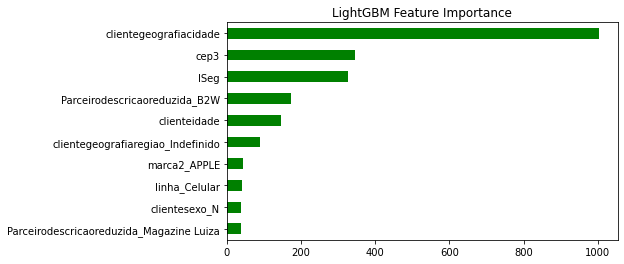

In [ ]:
lgbm_feature_importances = pd.Series(lgbm.feature_importances_, index=name_transformed_features).sort_values()
lgbm_feature_importances.tail(10).plot(kind='barh', figsize=(7,4), title='LightGBM Feature Importance', color='green');

## Feature Importance

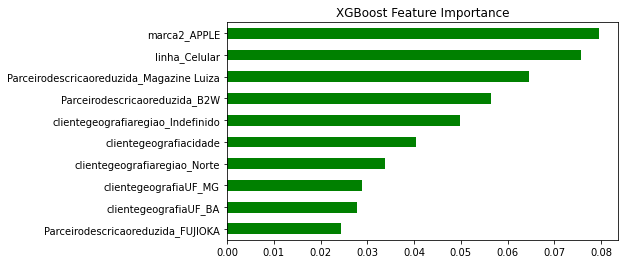

In [ ]:
xgb_feature_importances = pd.Series(xgb.feature_importances_, index=name_transformed_features).sort_values()
xgb_feature_importances.tail(10).plot(kind='barh', figsize=(7,4), title='XGBoost Feature Importance', color='green');

# Population Stability Index

## Função para calcular PSI de variáveis numéricas

In [ ]:
def calculate_psi(expected_array, actual_array, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI for a single variable
    Args:
       expected_array: numpy array of original values
       actual_array: numpy array of new values, same size as expected
       buckets: number of percentile ranges to bucket the values into
    Returns:
       psi_value: calculated PSI value
    '''
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    if buckettype == 'bins':
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

    expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
    actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

    def sub_psi(e_perc, a_perc):
        '''Calculate the actual PSI value from comparing the values.
           Update the actual value to a very small number if equal to zero
        '''
        if a_perc == 0:
            a_perc = 0.0001
        if e_perc == 0:
            e_perc = 0.0001

        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return(value)

    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return(psi_value)

## Calculando PSI para Variáveis Dummies

In [ ]:
X_train = pd.DataFrame(X_train, columns=name_transformed_features)
X_train['score'] = y_proba_train

X_test = pd.DataFrame(X_test, columns=name_transformed_features)
X_test['score'] = y_proba_test

X_oot = pd.DataFrame(X_oot, columns=name_transformed_features)
X_oot['score'] = y_proba_oot

In [ ]:
psi_df_dummies = (
    (X_train.filter(regex='_').sum() / len(X_train)).reset_index().rename(columns={'index': 'variable', 0: 'freq_train'})
    .merge((X_test.filter(regex='_').sum() / len(X_test)).reset_index().rename(columns={'index': 'variable', 0: 'freq_test'}),
           on='variable', how='left')
    .merge((X_oot.filter(regex='_').sum() / len(X_oot)).reset_index().rename(columns={'index': 'variable', 0: 'freq_oot'}),
           on='variable')
    .assign(psi_test = lambda df: np.where((df['freq_test'] == 0) | (df['freq_train'] == 0), 0, (df['freq_test'] - df['freq_train']) * np.log(df['freq_test'] / df['freq_train'])))
    .assign(psi_oot  = lambda df: np.where((df['freq_oot']  == 0) | (df['freq_train'] == 0), 0, (df['freq_oot']  - df['freq_train']) * np.log(df['freq_oot']  / df['freq_train'])))
    .filter(['variable', 'psi_test', 'psi_oot'])
)
psi_df_dummies

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,variable,psi_test,psi_oot
0,marca2_ALCATEL,0.015952,0.019944
1,marca2_APPLE,0.002008,0.013155
2,marca2_ASUS,0.000352,0.000004
3,marca2_DL,0.000175,0.000312
4,marca2_LENOVO,0.000108,0.001343
...,...,...,...
70,clientesexo_F,0.001956,0.000940
71,clientesexo_M,0.003926,0.003365
72,clientesexo_N,0.010179,0.000415
73,clientesexo_X,0.000081,0.000081


## Calculando PSI para variáveis numéricas

In [ ]:
psi_numerics_test = []
psi_numerics_oot  = []
for col in num_features + cat_features_high_card + ['score']:
    psi_numerics_test.append(calculate_psi(X_train[col], X_test[col]))
    psi_numerics_oot.append(calculate_psi(X_train[col], X_oot[col]))

psi_df_numerics = pd.DataFrame({'variable': num_features + cat_features_high_card + ['score'], 
                                'psi_test': psi_numerics_test,
                                'psi_oot': psi_numerics_oot})
psi_df_numerics

,variable,psi_test,psi_oot
0,ISeg,0.011401,0.008674
1,clienteidade,0.000507,0.000507
2,cep3,0.008783,0.018591
3,clientegeografiacidade,0.003319,0.004445
4,score,0.002703,0.020085


In [ ]:
psi_df = pd.concat([psi_df_numerics, psi_df_dummies])
psi_df

,variable,psi_test,psi_oot
0,ISeg,0.011401,0.008674
1,clienteidade,0.000507,0.000507
2,cep3,0.008783,0.018591
3,clientegeografiacidade,0.003319,0.004445
4,score,0.002703,0.020085
...,...,...,...
70,clientesexo_F,0.001956,0.000940
71,clientesexo_M,0.003926,0.003365
72,clientesexo_N,0.010179,0.000415
73,clientesexo_X,0.000081,0.000081


In [ ]:
psi_df['original_variable'] = psi_df['variable'].str.split('_').str[0]
psi_df

,variable,psi_test,psi_oot,original_variable
0,ISeg,0.011401,0.008674,ISeg
1,clienteidade,0.000507,0.000507,clienteidade
2,cep3,0.008783,0.018591,cep3
3,clientegeografiacidade,0.003319,0.004445,clientegeografiacidade
4,score,0.002703,0.020085,score
...,...,...,...,...
70,clientesexo_F,0.001956,0.000940,clientesexo
71,clientesexo_M,0.003926,0.003365,clientesexo
72,clientesexo_N,0.010179,0.000415,clientesexo
73,clientesexo_X,0.000081,0.000081,clientesexo


In [ ]:
psi_df.groupby('original_variable').sum().reset_index().rename(columns={'original_variable': 'variable'})

,variable,psi_test,psi_oot
0,ISeg,0.011401,0.008674
1,Parceirodescricaoreduzida,0.109123,0.343489
2,cep3,0.008783,0.018591
3,clientegeografiaUF,0.100312,0.085119
4,clientegeografiacidade,0.003319,0.004445
5,clientegeografiaregiao,0.040813,0.017046
6,clienteidade,0.000507,0.000507
7,clientesexo,0.038018,0.004800
8,linha,0.007676,0.014407
9,marca2,0.054748,0.148272


**Interpretation**:

* PSI do score < 0.1: no significant population change
* PSI do score < 0.2: moderate population change
* PSI do score >= 0.2: significant population change

Como ambos `psi_test` e `psi_oot` são menores que **0.1**, **0.002703** e **0.020085** respectivamente, logo nosso modelo está bem estável e pode continuar sendo usado com confiança.